# Lecture 12: Pitch estimation
Audio Processing, MED4, Aalborg University, 2020, By 
- Jesper Kjær Nielsen (jkn@create.aau.dk), Audio Analysis Lab, and
- Cumhur Erkut (cer@create.aau.dk), Multisensory Experience Lab.

Last edited: 2020-04-01

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Periodic-signals-revisited" data-toc-modified-id="Periodic-signals-revisited-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Periodic signals revisited</a></span><ul class="toc-item"><li><span><a href="#Pitch-vs.-fundamental-frequency" data-toc-modified-id="Pitch-vs.-fundamental-frequency-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Pitch vs. fundamental frequency</a></span></li><li><span><a href="#Why-is-the-fundamental-frequency-so-important?" data-toc-modified-id="Why-is-the-fundamental-frequency-so-important?-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Why is the fundamental frequency so important?</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Summary</a></span></li><li><span><a href="#Active-5-minutes-break" data-toc-modified-id="Active-5-minutes-break-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Active 5 minutes break</a></span></li></ul></li><li><span><a href="#Pitch-estimation:-comb-filtering" data-toc-modified-id="Pitch-estimation:-comb-filtering-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Pitch estimation: comb filtering</a></span><ul class="toc-item"><li><span><a href="#Summary" data-toc-modified-id="Summary-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Summary</a></span></li></ul></li><li><span><a href="#Pitch-estimation:-harmonic-summation" data-toc-modified-id="Pitch-estimation:-harmonic-summation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Pitch estimation: harmonic summation</a></span><ul class="toc-item"><li><span><a href="#Modelling-periodic-signals" data-toc-modified-id="Modelling-periodic-signals-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Modelling periodic signals</a></span></li><li><span><a href="#Harmonic-summation" data-toc-modified-id="Harmonic-summation-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Harmonic summation</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Summary</a></span></li><li><span><a href="#Playtime-with-Jack-Schaedler's-tools-(Ableton)" data-toc-modified-id="Playtime-with-Jack-Schaedler's-tools-(Ableton)-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Playtime with Jack Schaedler's tools (Ableton)</a></span></li></ul></li></ul></div>

## Periodic signals revisited
In the next 20 minutes, you will learn
- what a periodic signal is
- what the pitch (fundamental frequency) is
- why pitch estimation is so important

A periodic signal is a signal which **repeats itself**.
<center>
<img src="figures/isTheSignalPeriodic0.png" alt="Sinusoid" width="50%"/>
</center>

Mathematically, we can write this as
$$
    x_n = x_{n-\tau}
$$
for some period $\tau$ (in samples).

In lecture 1, we saw that the vibrations on a guitar string were periodic.

#### Is this signal periodic?
<center>
<img src="figures/isTheSignalPeriodic1.png" alt="Sinusoid" width="70%"/>
</center>

#### Is this signal periodic?
<center>
<img src="figures/isTheSignalPeriodic2.png" alt="Sinusoid" width="70%"/>
</center>

#### Is this signal periodic?
<center>
<img src="figures/isTheSignalPeriodic3.png" alt="Sinusoid" width="70%"/>
</center>

#### Is this signal periodic?
<center>
<img src="figures/isTheSignalPeriodic4.png" alt="Sinusoid" width="70%"/>
</center>

A periodic signal repeats its values after a number of samples $\tau$, i.e., 
$$
    x_n = x_{n-\tau}\ .
$$

Note that
1. if you know the function values for one period $n\in[0,\tau-1)$, say, then you know the function for all times $n\in(-\infty,\infty)$
2. the inverse of the period $\tau$ is called the **fundamental frequency** (sometimes also **pitch**) of the periodic signal and denoted by $f_0$, i.e., 
$$
    f_0 = 1/\tau\quad \text{[cycles/sample]}\ .
$$
The fundamental frequency describes how many times the signals $x_n$ repeats itself pr. sample
3. the **goal of pitch estimation** to estimate the period $\tau$ from (possibly) noisy data

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wave
import IPython.display as ipd

try:
  import google.colab
  IN_COLAB = True
  !mkdir -p data
  !wget https://raw.githubusercontent.com/SMC-AAU-CPH/med4-ap-jupyter/main/lectureB_Dynamic_Range_Control/data/guitar.ff.sulB.B3.wav -P data
except:
  IN_COLAB = False

# load a guitar signal
samplingFreq, guitarSignal = wave.read('data/guitar.ff.sulB.B3.wav')
guitarSignal = guitarSignal/2**15 # normalise
ipd.Audio(guitarSignal, rate=samplingFreq) 

In [3]:
# setup
tStart = 0.45 # s
tEnd =0.47 #
startIdx = int(tStart*samplingFreq)
endIdx = int(tEnd*samplingFreq)
time = np.arange(startIdx,endIdx)/samplingFreq
nData = np.size(time)

In [4]:
# compute the pitch period (rounded to the nearest integer for a the B3 note (pitch of 246.94 Hz))
pitch = 246.94 # Hz
pitchPeriod = samplingFreq/pitch
integerPitchPeriod = int(np.round(pitchPeriod))
print('For the B3 note (i.e., '+ str(pitch) + ' Hz), the pitch period is ' + str(pitchPeriod) + ' samples.')

For the B3 note (i.e., 246.94 Hz), the pitch period is 178.58589130962986 samples.


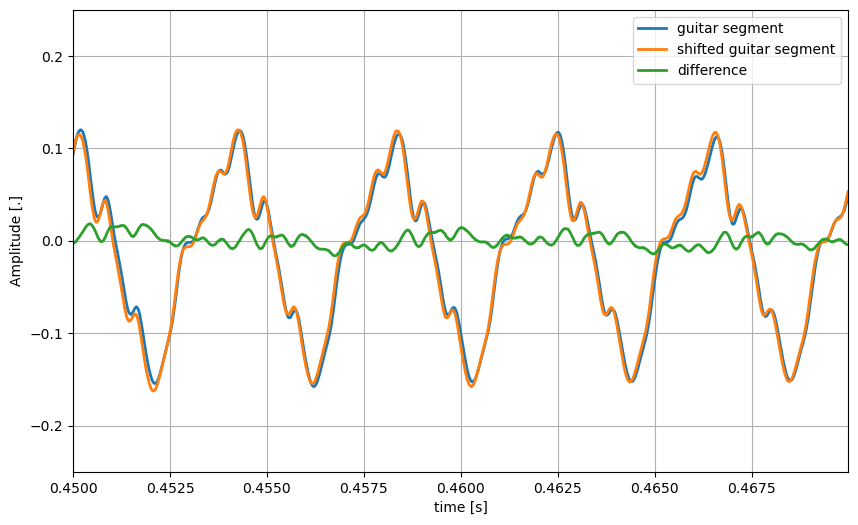

In [5]:
#extract a segment
dataSegment = guitarSignal[startIdx:endIdx]
segmentShift = integerPitchPeriod
shiftedDataSegment = guitarSignal[startIdx-segmentShift:endIdx-segmentShift]

# plot the data segment
plt.figure(figsize=(10,6))
plt.plot(time,dataSegment,linewidth=2,label="guitar segment")
plt.plot(time,shiftedDataSegment,linewidth=2,label="shifted guitar segment")
plt.plot(time,dataSegment-shiftedDataSegment,linewidth=2,label="difference")
plt.xlim((time[0],time[nData-1])),plt.ylim((-0.25,0.25)),plt.grid(True),plt.legend()
plt.xlabel('time [s]'),plt.ylabel('Amplitude [.]');

### Pitch vs. fundamental frequency
The fundamental frequency is a **physical property** which is very closely related to the **perceptual property pitch**.

The pitch is
1. **Def. 1**: that attribute of auditory sensation in terms of which sounds may be ordered on a musicalscale (Acoustical Society of America (ASA))
2. **Def. 2**:  that attribute of auditory sensation in terms of which sounds may be ordered on a scale extending from low to high (American National Standards Institute (ANSI))

Formally, pitch $\neq$ fundamental frequency, but many people use pitch $=$ fundamental frequency (as do we here).

### Why is the fundamental frequency so important?
You have to estimate the fundamental frequency if
- you want to tune your instrument
- you want to do music transcription
- you want to separate different instruments/talkers in a mixture
- if you want to measure the rotation speed of an engine or a wheel
- if you want to know your heart rate
- . . . etc.

### Summary
1. A periodic signal satisfies
$$
    x_n = x_{n-\tau}
$$
for some $\tau$. The smallest time $\tau$ satisfying the above is referred to as the **period** of the signal.
2. The inverse of the period, i.e.,
$$
    f_0 = 1/\tau\ \text{[cycles/sample]}
$$
is the fundamental frequency or pitch.
3. Many signals are approximately periodic.

### Active 5 minutes break
1. Is the signal in the figure periodic?
2. What is the pitch period and pitch (approximately)?
3. Discuss with your neighbour, how you would estimate the fundamental frequency using a computer.

<center>
<img src="figures/isTheSignalPeriodic4WithTime.png" alt="Sinusoid" width="70%"/>
</center>

## Pitch estimation: comb filtering
In the next 20 minutes, you will learn
- how you can estimate the fundamental frequency using correlation-based methods (i.e., comb filtering)
- why it is hard to estimate the fundamental frequency

<center>
<img src="figures/isTheSignalPeriodic4WithTime.png" alt="Sinusoid" width="50%"/>
</center>
For a periodic signal $x_n$ with period $\tau$, we have that
$$
    x_{n} = x_{n-\tau}\ .
$$

1. Unfortunately, $\tau$ is unknown so we have to try out different $\tau$'s to find one that satisfies the above equation.
2. Real-world signals are not perfectly period so we might never find one.
3. Instead, the estimate of $\tau$ is the value which minimises some the power of an error signal.

Let us define an error signal $e_n$ as
$$
    e_n = x_n - a x_{n-\tau}\ .
$$

Thus, we can interpret the error signal as the output of a **feedforward comb filter** having
- $x_n$ as the input, 
- $\tau$ as the delay, and
- $-a$ as the filter coefficient.

<center>
<img src="figures/ap12FeedforwardCombFilter.png" alt="Feedforward comb filter" width="60%"/>
</center>

We know neither the delay $\tau$, which is the sought after pitch period, nor the filter coefficient $a$.

From $N$ input samples $x_0, x_1, \ldots, x_{N-1}$, these are estimated by minimising
$$
    J(a,\tau) = \sum_{n=\tau_\text{MAX}}^{N-1} e_{n}^2 = \sum_{n=\tau_{MAX}}^{N-1} (x_n - a x_{n-\tau})^2\ .
$$

Thus, we could simply try out different values for $a > 0$ and $\tau_\text{MIN} \leq \tau \leq \tau_\text{MAX}$ and calculate $J(a,\tau)$ for each combination of $a$ and $\tau$. The combination that minimises $J(a,\tau)$ is then our estimate.

#### Minimising $J(a,\tau)$
After doing some math, it can be shown that the estimates of $\tau$ and $a$ are given by
\begin{align}
    \hat{\tau} &= \underset{\tau\in[\tau_\text{MIN},\tau_\text{MAX}]}{\mathrm{argmax}} \max(\phi(\tau),0)\\
    \hat{a} &= \frac{\sum_{n=\tau_\text{MAX}}^{N-1} x_{n}x_{n-\hat{\tau}}}{\sum_{n=\tau_\text{MAX}}^{N-1} x_{n-\hat{\tau}}^2}
\end{align}
where $\phi(\tau)$ is the so-called **normalised autocorrelation function** given by
$$
    \phi(\tau) = \sum_{n=\tau_\text{MAX}}^{N-1} \tilde{x}_n \tilde{x}_{n-\tau}
$$
with
\begin{align}
    \tilde{x}_{n-\tau} = \frac{x_{n-\tau}}{\sqrt{\sum_{n=\tau_\text{MAX}}^{N-1}x_{n-\tau}^2}}
\end{align}

#### Example: computing the normalised autocorrelation function
<center>
<img src="figures/ap12CombCostExample1.png" alt="Comb filter illustation 1" width="80%"/>
</center>

<center>
<img src="figures/ap12CombCostExample2.png" alt="Comb filter illustation 2" width="80%"/>
</center>

<center>
<img src="figures/ap12CombCostExample3.png" alt="Comb filter illustation 3" width="80%"/>
</center>

<center>
<img src="figures/ap12CombCostExample4.png" alt="Comb filter illustation 4" width="80%"/>
</center>

<center>
<img src="figures/ap12CombCostExample5.png" alt="Comb filter illustation 5" width="80%"/>
</center>

Many pitch estimators are based on comb filtering principle:
- **PRAAT**: (Boersma, 1993), well over 1000 citations (Google Scholar)
- **RAPT**: (Talkin, 1995), nearly 1000 citations (Google Scholar)
- **YIN**:  (Cheveigné, 2002), nearly 2000 citations (Google Scholar)
- **Kaldi**:  (Ghahremani et al., 2014), nearly 200 citations (Google Scholar)

They differ in how the (try to) solve the following problems:
1. limit the amount of subharmonic errors (i.e., estimating the pitch to be, e.g., 50 Hz or 33 Hz when the true pitch is 100 Hz)
2. robustness to noise

In [8]:
def combFilterPitchEstimation(inputSignal, minPitch, maxPitch):
    minPeriod = int(np.ceil(2*np.pi/maxPitch))
    maxPeriod = int(np.floor(2*np.pi/minPitch)) 
    periodGrid = np.arange(minPeriod, maxPeriod+1)
    nPitches = np.size(periodGrid)
    normAutoCorr = np.zeros(nPitches)
    signal = inputSignal[maxPeriod:]
    signalPower = np.sum(signal**2)
    for ii in np.arange(nPitches):
        iiPeriod = periodGrid[ii]
        shiftedSignal = inputSignal[maxPeriod-iiPeriod:-iiPeriod]
        shiftedSignalPower = np.sum(shiftedSignal**2)
        normAutoCorr[ii] = np.max((np.sum(signal*shiftedSignal)/np.sqrt(signalPower*shiftedSignalPower),0))
    estPeriodIdx = np.argmax(normAutoCorr)
    estDigPitch = 2*np.pi/periodGrid[estPeriodIdx]
    return estDigPitch, periodGrid, normAutoCorr

In [9]:
minDigPitch = 50*2*np.pi/samplingFreq # radians/sample
maxDigPitch = 1000*2*np.pi/samplingFreq # radians/sample
estDigPitch, periodGrid, normAutoCorr = combFilterPitchEstimation(guitarSignal, minDigPitch, maxDigPitch)
print('An ideal B3 note has a pitch of 246.94 Hz.')
print('The estimated pitch is '+ str(estDigPitch*samplingFreq/(2*np.pi)) + ' Hz.')
ipd.Audio(guitarSignal, rate=samplingFreq) 

An ideal B3 note has a pitch of 246.94 Hz.
The estimated pitch is 246.3687150837989 Hz.


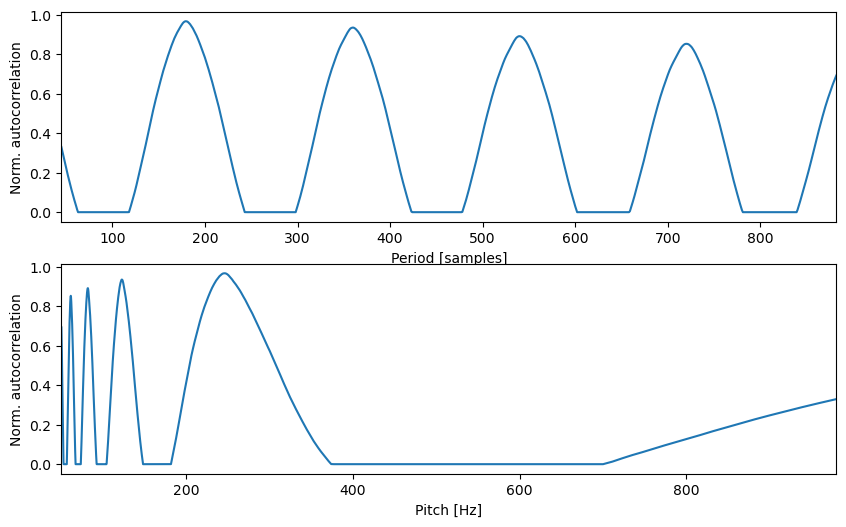

In [10]:
pitchGrid = samplingFreq/periodGrid[::-1]
plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
plt.plot(periodGrid, normAutoCorr)
plt.xlim((periodGrid[0],periodGrid[-1])), plt.xlabel('Period [samples]'), plt.ylabel('Norm. autocorrelation')
plt.subplot(2,1,2)
plt.plot(pitchGrid, normAutoCorr[::-1])
plt.xlim((pitchGrid[0],pitchGrid[-1])), plt.xlabel('Pitch [Hz]'), plt.ylabel('Norm. autocorrelation');

### Summary
1. We can estimate the pitch by adjusting the delay and filter coefficient of a feedforward comb filter until the power of its output is minimised.
2. Many pitch estimators are based on this principle

<center>
<img src="figures/ap12FeedforwardCombFilter.png" alt="Feedforward comb filter" width="60%"/>
</center>

## Pitch estimation: harmonic summation
In the next 20 minutes, you will learn
- how we model a periodic signal
- what the harmonic summation pitch estimator is

### Modelling periodic signals
<center>
<img src="figures/speechDecomposition.png" alt="Speech as a linear combination of sinusoids" width="90%"/>
</center>

<center>
<img src="figures/speechDecompositionApprox.png" alt="Speech as a linear combination of sinusoids - approximation" width="90%"/>
</center>
If the signal was exactly periodic, the error would be zero.

The signal model of any periodic signal is
$$
    s_n = \sum_{l=1}^L h_n^{(l)} = \sum_{l=1}^L A_l\cos(l\omega_0 n + \phi_l)
$$
where
- $\omega_0$ is the fundamental frequency or pitch in radians/samples
- $L$ is the number of harmonic components (or model order)
- $A_l$ is the amplitude of the $l$'th harmonic component
- $\phi_l$ is the phase of the $l$'th harmonic component

These parameters are here all assumed unknown, except for the model order $L$.

### Harmonic summation
To estimate the pitch, amplitudes, and phases (the model parameters), we define the error signal
$$
    e_n = x_n - s_n = x_n - \sum_{l=1}^L A_l\cos(l\omega_0 n + \phi_l)\ .
$$

Thus, the error is the difference between the observed signal and the model of the signal.

The idea is now to estimate the model parameters as the values which minimise
$$
    J(A_1,\ldots,A_L, \phi_1, \ldots, \phi_L, \omega_0) = \sum_{n=0}^{N-1} e_n^2
$$
based on the observations $x_0, x_1, \ldots, x_{N-1}$.

If we have enough data (i.e., if $N$ is large enough), we can use **Parseval's theorem** to get
$$
    J(A_1,\ldots,A_L, \phi_1, \ldots, \phi_L, \omega_0) \approx \frac{1}{2\pi} \int_{-\pi}^\pi |E(\omega)|^2d\omega
$$
where $E(\omega)$ is the DTFT (or freqeuncy response) of the error signal.

After a lot of math, it can be shown that we can estimate the pitch as
$$
    \hat{\omega}_0 = \underset{\omega_0\in[\omega_\text{MIN},\omega_\text{MAX}]}{\mathrm{argmax}} \sum_{l=1}^L|X(l\omega_0)|^2
$$
where $X(\omega)$ is the DTFT of the input signal.

This estimator is called the **harmonic summation estimator**.

<center>
<img src="figures/ap12HsIllustration.png" alt="Harmonic summation illustration" width="60%"/>
</center>

In [11]:
def harmonicSummation(inputSignal, minDigPitch, maxDigPitch, modelOrder):
    nData = np.size(inputSignal)
    nDft = 5*nData*modelOrder # rule of thumb: we need at least this amount of grid points
    dftSignal = np.fft.fft(inputSignal, nDft)
    # ensure that pitchOrder*maxDigPitch is smaller than the Nyquist frequency
    maxDigPitch = np.min((maxDigPitch, np.pi/modelOrder))
    # compute the grid of dft indices between the pitch bounds
    pitchDftIndices = computeValidDftIndices(minDigPitch, maxDigPitch, nDft)
    # compute the harmonic summation objection function
    hsObjective = computeHsObjective(dftSignal, pitchDftIndices, modelOrder)
    # compute the pitch estimate
    idx = np.argmax(hsObjective)
    estDigPitch = 2*np.pi*pitchDftIndices[idx]/nDft
    return estDigPitch, 2*np.pi*pitchDftIndices/nDft, hsObjective

In [12]:
def computeValidDftIndices(minDigPitch, maxDigPitch, nDft):
    minDftIndex = int(np.ceil(nDft*minDigPitch/(2*np.pi)))
    maxDftIndex = int(np.floor(nDft*maxDigPitch/(2*np.pi)))
    dftIndices = np.arange(minDftIndex,maxDftIndex+1)
    return dftIndices

def computeHsObjective(dftSignal, pitchDftIndices, modelOrder):
    nPitches = np.size(pitchDftIndices)
    hsObjective = np.zeros(nPitches)
    for ii in np.arange(1,modelOrder+1):
        iiDftIndices = pitchDftIndices*ii
        hsObjective = hsObjective + np.abs(dftSignal[iiDftIndices])**2
    return hsObjective

In [13]:
minDigPitch = 50*2*np.pi/samplingFreq # radians/sample
maxDigPitch = 1000*2*np.pi/samplingFreq # radians/sample
modelOrder = 5
estDigPitch, digPitchGrid, hsObjective = harmonicSummation(guitarSignal, minDigPitch, maxDigPitch, modelOrder)
print('An ideal B3 note has a pitch of 246.94 Hz.')
print('The estimated pitch is '+ str(estDigPitch*samplingFreq/(2*np.pi)) + ' Hz.')
ipd.Audio(guitarSignal, rate=samplingFreq) 

An ideal B3 note has a pitch of 246.94 Hz.
The estimated pitch is 244.47282622389073 Hz.


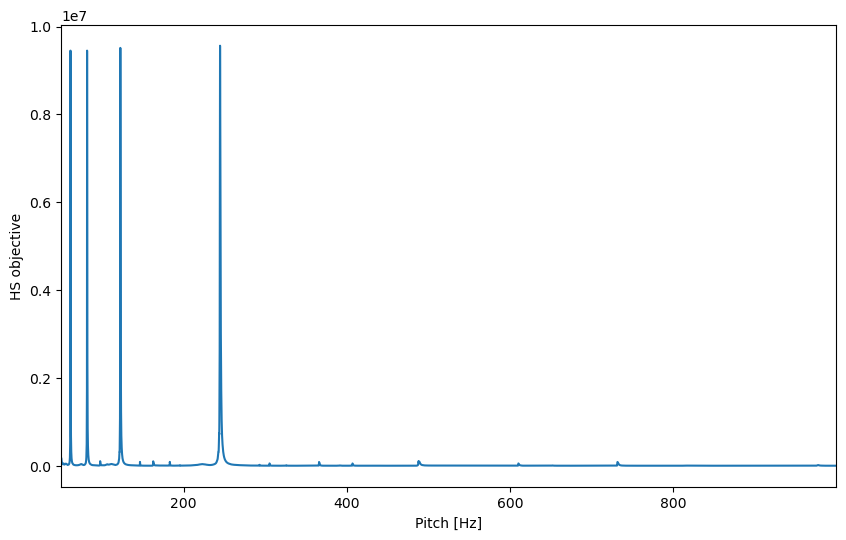

In [14]:
pitchGrid = digPitchGrid*samplingFreq/(2*np.pi)
plt.figure(figsize=(10,6))
plt.plot(pitchGrid, hsObjective)
plt.xlim((pitchGrid[0],pitchGrid[-1])), plt.xlabel('Pitch [Hz]'), plt.ylabel('HS objective');

### Summary
1. The signal model of any periodic signal is
$$
    s_n = \sum_{l=1}^L A_l\cos(l\omega_0 n + \phi_l)
$$
where
 - $\omega_0$ is the fundamental frequency or pitch in radians/samples
 - $L$ is the number of harmonic components (or model order)
 - $A_l$ is the amplitude of the $l$'th harmonic component
 - $\phi_l$ is the phase of the $l$'th harmonic component
2. We can estimate the pitch using the harmonic summation (HS) pitch estimator as
$$
    \hat{\omega}_0 = \underset{\omega_0\in[\omega_\text{MIN},\omega_\text{MAX}]}{\mathrm{argmax}} \sum_{l=1}^L|X(l\omega_0)|^2
$$
where $X(\omega)$ is the DTFT of the observed signal.

### Playtime with Jack Schaedler's tools (Ableton)

- https://www.objc.io/issues/24-audio/audio-dog-house/
- https://jackschaedler.github.io/circles-sines-signals

